In [28]:
# Import and install all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
#! pip install lifelines==0.26.4
!pip install lifelines
import lifelines


In [29]:
data = pd.read_csv('/Users/school/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [30]:
pd.set_option('display.max_columns', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
data.loc[488,'TotalCharges']

' '

In [32]:
# Replace single white space with MonthlyCharges and convert to numeric
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'])
data['TotalCharges'].replace(' ', np.nan, inplace=True)
data.dropna(subset=['TotalCharges'], inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

# Save customerID and MonthlyCharges columns in a separate DF and drop customerID from the main DF
churned_customers = data[data['Churn'] == 'No']
customerID = pd.DataFrame(churned_customers[['customerID', 'MonthlyCharges']])
data.drop(columns = ['customerID'], inplace=True)

# We will also create a copy of DF that will be utilised later to plot categorical KM Curves
data_kmf = data.copy()


In [33]:
# Convert Churn column to 1 (Yes) or 0 (No)
data['Churn'] = data['Churn'].replace({"No": 0, "Yes": 1})

Note that some features has 3 categories

In [34]:
# Create a list of features where we will assign 1 to a Yes value and 0 otherwise
features_to_combine = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
   'TechSupport', 'StreamingTV', 'StreamingMovies']
# Assign 1 to Yes and 0 otherwise
for feat in features_to_combine:
    data[feat] = data[feat].apply(lambda x: 1 if x == 'Yes' else 0)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,0,DSL,0,1,0,0,0,0,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,0,DSL,1,0,1,0,0,0,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,0,DSL,1,1,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,0,DSL,1,0,1,1,0,0,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [36]:
# Create dummy variables for our remaining categorical columns
data = pd.get_dummies(data, columns = ['gender', 'Partner', 'Dependents', 'PhoneService',
                     'InternetService', 'Contract', 'PaperlessBilling',
                        'PaymentMethod'], drop_first = False)

In [37]:

# Drop that dummy variable that the business considers to be typical of their subscribers
data.drop(columns = ['gender_Male', 'Partner_Yes', 'Dependents_No', 'PhoneService_Yes',
   'InternetService_Fiber optic', 'Contract_Month-to-month', 'PaperlessBilling_Yes',
    'PaymentMethod_Electronic check'], inplace = True)

In [38]:
data.head()

,SeniorCitizen,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Churn,gender_Female,Partner_No,Dependents_Yes,PhoneService_No,InternetService_DSL,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check
0,0,1,0,0,1,0,0,0,0,29.85,29.85,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,34,0,1,0,1,0,0,0,56.95,1889.50,0,0,1,0,0,1,0,1,0,1,0,0,1
2,0,2,0,1,1,0,0,0,0,53.85,108.15,1,0,1,0,0,1,0,0,0,0,0,0,1
3,0,45,0,1,0,1,1,0,0,42.30,1840.75,0,0,1,0,1,1,0,1,0,1,1,0,0
4,0,2,0,0,0,0,0,0,0,70.70,151.65,1,1,1,0,0,0,0,0,0,0,0,0,0


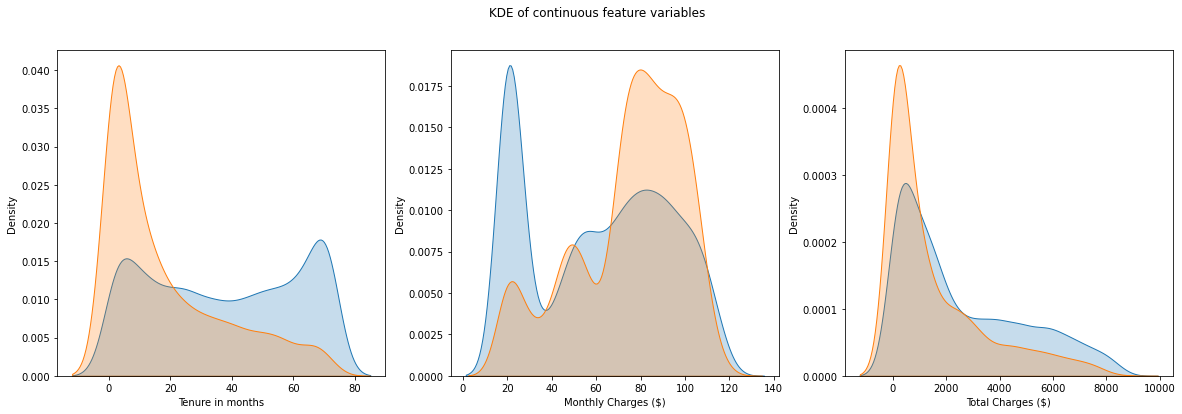

In [43]:
# Visualise the numerical features

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.suptitle("KDE of continuous feature variables")
# tenure
sns.kdeplot(data['tenure'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax1)
sns.kdeplot(data['tenure'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax1)
ax1.set_xlabel("Tenure in months")
# monthly charges
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax2)
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax2)
ax2.set_xlabel("Monthly Charges ($)")
# total charges
sns.kdeplot(data['TotalCharges'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax3)
sns.kdeplot(data['TotalCharges'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax3)
ax3.set_xlabel("Total Charges ($)");

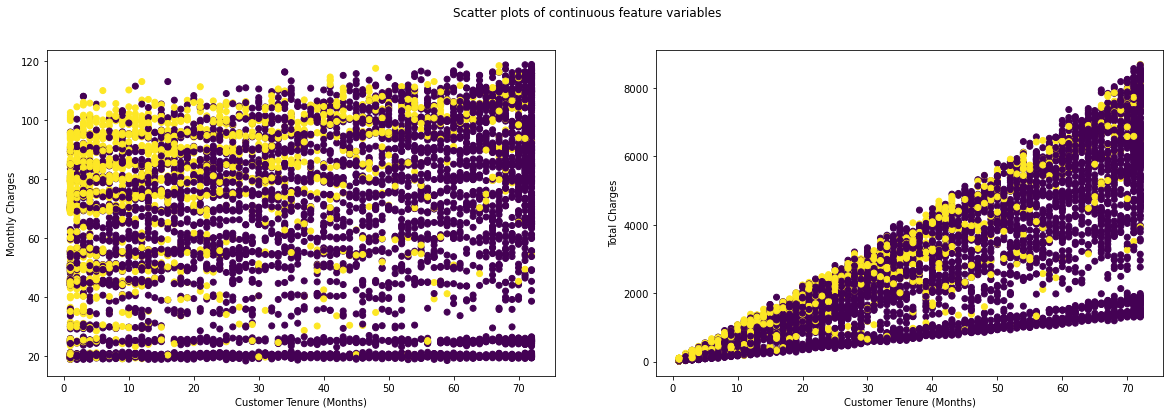

In [42]:
# Visualise scatter plots of tenure against monthly and total charges based on churn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle("Scatter plots of continuous feature variables")

# Monthly Charges
ax1.scatter(data['tenure'], data['MonthlyCharges'], c=data['Churn']) 
ax1.set_xlabel('Customer Tenure (Months)')
ax1.set_ylabel('Monthly Charges')

# Total Charges
ax2.scatter(data['tenure'], data['TotalCharges'], c=data['Churn']) 
ax2.set_xlabel('Customer Tenure (Months)')
ax2.set_ylabel('Total Charges');

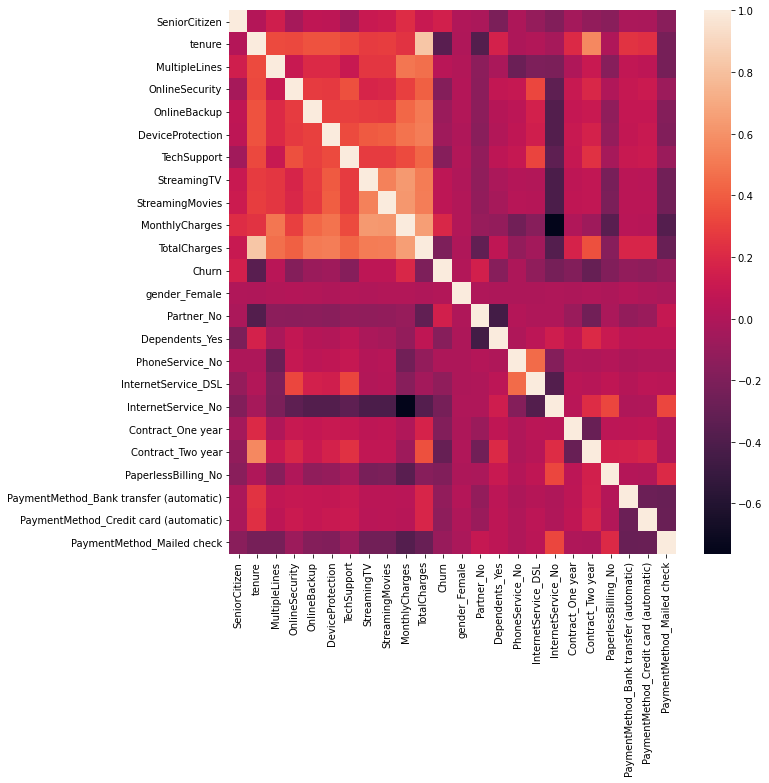

In [44]:
# Let's check for multicollinearity as it is a basic assumption of the CPH model
fig = plt.figure(figsize=(10,10))
corrmat = data.corr()
sns.heatmap(corrmat);

Log rank test 

In [45]:
# Update Churn column of data_kmf that we kept aside for this moment before feature engineering
data_kmf['Churn'] = data_kmf['Churn'].replace({"No": 0, "Yes": 1})

In [46]:
# save indices for each contract type
idx_m2m = data_kmf['Contract'] == 'Month-to-month'
idx_1y = data_kmf['Contract'] == 'One year'
idx_2y = data_kmf['Contract'] == 'Two year'

In [47]:
from lifelines.statistics import logrank_test
T1 = data_kmf.loc[idx_m2m, 'tenure']
T2 = data_kmf.loc[idx_1y, 'tenure']
E1 = data_kmf.loc[idx_m2m, 'Churn']
E2 = data_kmf.loc[idx_1y, 'Churn']
results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)


In [48]:
results.print_summary()
print(results.p_value)        
print(results.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         926.06 <0.005    673.27

2.1173266936012146e-203
926.0645586243704


Since the p-value is less than 0.005 we reject the Null hypothesis. This suggests there is evidence against 
the 2 contract types ignoring other factors. Those with a month to month seems to have shorter survival time 
than the 1 year contract, ignoring other factors.

However there are several limitations in that we can't test multiple hypothesis at the same time. 

Also since KM is non parametric we can't summarize the relationship with a number/ coefficient. We would require
the below graph to express the relationship.

KM is only a good initial starting point, to really address for confounders and to create something with
more predictive power we move next to the CPHM

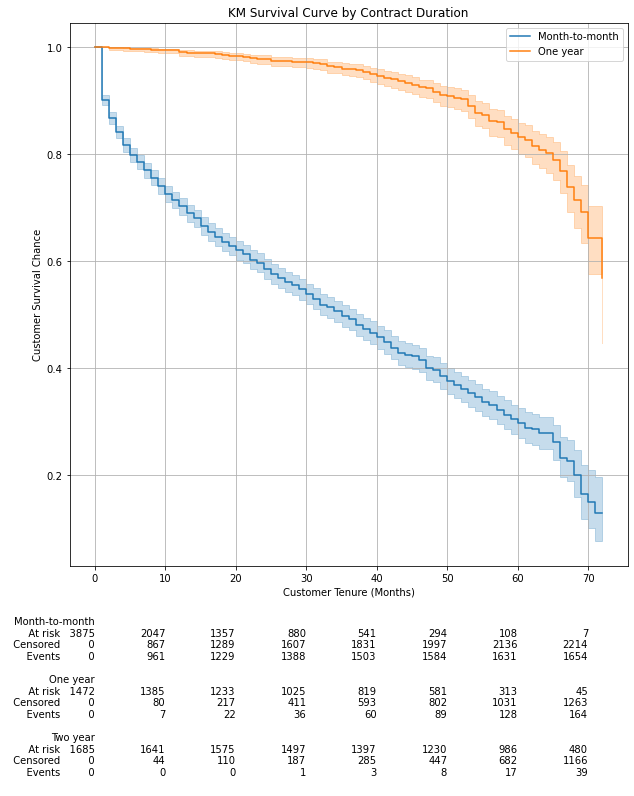

In [50]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
kmf_m2m = lifelines.KaplanMeierFitter()
ax = kmf_m2m.fit(durations = T1, event_observed = E1, label = 'Month-to-month').plot(ax = ax)
kmf_1y = lifelines.KaplanMeierFitter()
ax = kmf_1y.fit(durations = T2, event_observed = E2, label = 'One year').plot(ax = ax)


ax.set_title('KM Survival Curve by Contract Duration')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_m2m, kmf_1y, kmf_2y, ax = ax);

Cox Proportional Hazards Model

In [51]:
# Instantiate and fit CPH model
cph = lifelines.CoxPHFitter()
cph.fit(data, duration_col = 'tenure', event_col = 'Churn')

# Print model summary
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

/Users/school/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/printer.py:74: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns & self.columns
/Users/school/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/printer.py:61: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns & self.columns


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12659.693
         time fit was run = 2022-01-09 20:05:56 UTC
                    model = base model

---
                                          coef  exp(coef)       p
covariate                                                        
SeniorCitizen                            0.034      1.035   0.543
MultipleLines                            0.087      1.091   0.489
OnlineSecurity                          -0.213      0.808   0.109
OnlineBackup                            -0.056      0.946   0.661
DeviceProtection                         0.088      1.092   0.489
TechSupport                             -0.084      0.919   0.524
StreamingTV                              0.281      1.325   0.233
StreamingMovies                          0.287      1.332   0.224
MonthlyCharges                           0.013      1.013   0.567
TotalCharges                            -0.002      0.998 <0.0005
gender_Female                            0.039      1.040   0.398
Partner_No                               0.178      1.195   0.001
Dependents_Yes                          -0.092      0.913   0.190
PhoneService_No                         -0.828      0.437   0.081
InternetService_DSL                     -1.017      0.362   0.079
InternetService_No                      -3.356      0.035   0.004
Contract_One year                       -1.266      0.282 <0.0005
Contract_Two year                       -3.701      0.025 <0.0005
PaperlessBilling_No                     -0.150      0.861   0.008
PaymentMethod_Bank transfer (automatic) -0.387      0.679 <0.0005
PaymentMethod_Credit card (automatic)   -0.399      0.671 <0.0005
PaymentMethod_Mailed check               0.123      1.131   0.077
---
Concordance = 0.929
Partial AIC = 25363.386
log-likelihood ratio test = 5986.693 on 22 df
-log2(p) of ll-ratio test = inf